In [1]:
# %load_ext autoreload
# %autoreload 2

In [1]:
import numpy as np
%load_ext line_profiler

In [2]:
%cd ..

D:\dev\bayes-crm


In [3]:
import scipy.stats as st
from crm.levy_processes import *
from crm.crm_approx import *
from crm.fk import *
from crm.utils.general_utils import measure_time_process
from crm.utils.levy_process_utils import *
from crm.two_piece_envelope import two_envelope_beta

plt.style.use("bmh")

In [5]:
m = 1
c = 2
sigma = 0.5

# Beta Process speed

In [37]:
num_fits = 1000

In [7]:
fk_time = measure_time_process(ferguson_klass, int(num_fits/10), beta_process(m, c), size=100)
fk_time

100%|██████████| 100/100 [00:11<00:00,  9.01it/s]


0.11103469848632813

In [8]:
start_time = time.time()
for _ in range(num_fits):
    x = two_envelope_beta(m, c, 100)
env_time = (time.time() - start_time) / num_fits
env_time

1.9948482513427736e-06

In [42]:
my_time = {}
for n in tqdm([101, 1001, 10001, 100001, 1000001]):
    #my_time[n] = measure_time_approx_process(num_fits, beta_process(m, c), n, g_beta_process(m, c), -1, size=100, thr=0.5)
    my_time[n] = measure_time_approx_process(num_fits, beta_process(m, c), n,  size=100)

100%|██████████| 1000/1000 [00:00<00:00, 14122.52it/s]

100%|██████████| 5/5 [02:16<00:00, 27.22s/it]


In [10]:
env_time / my_time[1001]

0.01613058700144977

In [11]:
fk_time / my_time[1001]

897.8401554643883

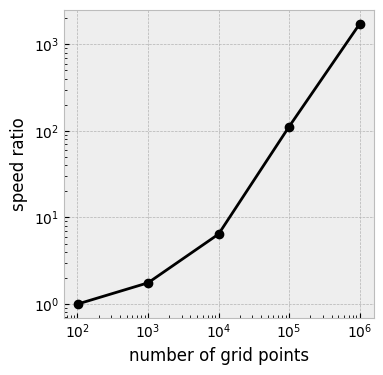

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.loglog(np.array(list(my_time.keys())), np.array(list(my_time.values())) / my_time[101], marker="o", c="black")
ax.set_xlabel("number of grid points")
ax.set_ylabel("speed ratio")
fig.savefig("beta_process_speed_vs_grid_size.pdf", bbox_inches="tight")

In [20]:
my_time = {}
num_fits = 1000
for n in tqdm([101, 1001, 10001, 100001]):
    #my_time[n] = measure_time_approx_process(num_fits, gamma_process(1), n, g_gamma_process(1), -1, size=100, thr=0.5, bounds=(1e-10, np.inf))
    my_time[n] = measure_time_approx_process(num_fits, gamma_process(1), n, size=100, bounds=(1e-10, np.inf))

100%|██████████| 4/4 [00:33<00:00,  8.27s/it]


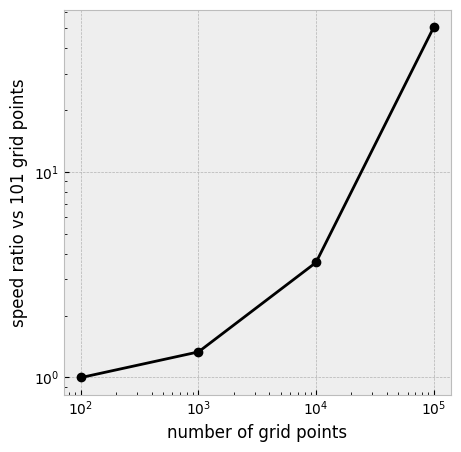

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.loglog(my_time.keys(), np.array(list(my_time.values())) / my_time[101], marker="o", c="black")
ax.set_xlabel("number of grid points")
ax.set_ylabel("speed ratio vs 101 grid points")
fig.savefig("gamma_process_speed_vs_grid_size.pdf", bbox_inches="tight")

# Beta Process accuracy

In [12]:
num_fits = 10
c = 2
m = 1
n_grids = [1001, 10001, 100001, 1000001]

In [13]:
errors, jump_sizes = process_errors_and_jump_sizes(num_fits, beta_process, {"m": m, "c": c}, n_grids, g_beta_process, use_trap=False, thr=0.5, cache=False)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
n_grids = [501, 5001, 50001, 500001]
errors_trap, jump_sizes_trap = process_errors_and_jump_sizes(num_fits, beta_process, {"m": m, "c": c}, n_grids, g_beta_process, use_trap=True, cache=False, bounds=(1e-5, 1))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

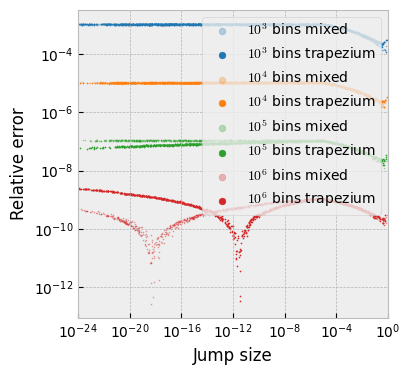

In [12]:
plot_errors_and_jump_sizes(jump_sizes, errors, n_grids, jump_sizes_trap, errors_trap, "error_beta_m_1_c_2_thr_50_new_trap.pdf") # "error_beta_m_1_c_2_thr_50.pdf"

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

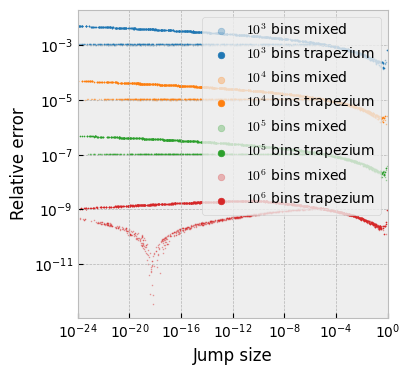

In [9]:
plot_errors_and_jump_sizes(jump_sizes, errors, n_grids, jump_sizes_trap, errors_trap, "error_beta_m_1_c_2_thr_50.pdf") # "error_beta_m_1_c_2_thr_50.pdf"

(<Figure size 500x500 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

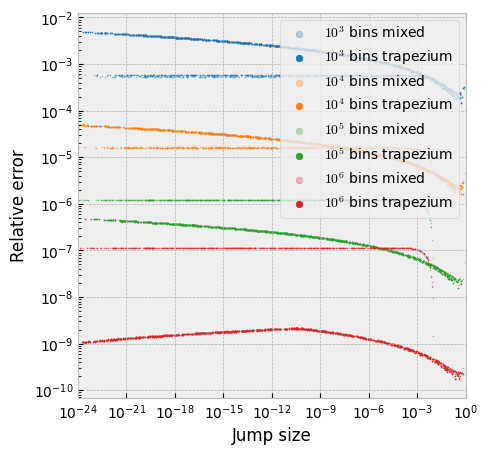

In [9]:
plot_errors_and_jump_sizes(jump_sizes, errors, n_grids, jump_sizes_trap, errors_trap, "error_beta_m_1_c_2_thr_80.pdf") #

# Stable Beta Process accuracy

In [7]:
num_fits = 5
c = 2
m = 1
sigma = 0.1
n_grids = [1001, 10001, 100001, 1000001] # 1001, 10001, 100001,

In [8]:
errors, jump_sizes = process_errors_and_jump_sizes(num_fits, stable_beta_process, {"m": m, "c": c, "sigma": sigma}, n_grids, g_stable_beta_process, use_trap=False, thr=0.5, n_jumps=1000)

In [10]:
n_grids = [501, 5001, 50001, 500001]
errors_trap, jump_sizes_trap = process_errors_and_jump_sizes(num_fits, stable_beta_process, {"m": m, "c": c, "sigma": sigma}, n_grids, g_stable_beta_process, use_trap=True, n_jumps=1000, bounds=(1e-5, 1))

  0%|          | 0/5 [00:00<?, ?it/s]

D:\dev\bayes-crm\crm\fk.py:115: RuntimeWarning: overflow encountered in exp
  return const1 * np.exp(-sigma * x + (c + sigma - 1) * np.log(1 - np.exp(x)))


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

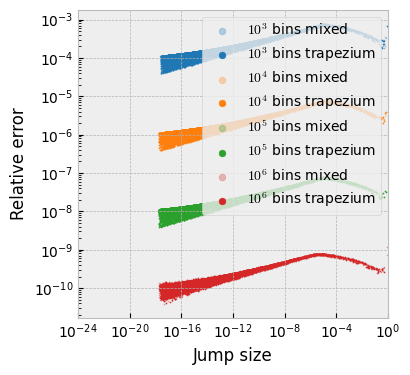

In [11]:
plot_errors_and_jump_sizes(jump_sizes, errors, n_grids, jump_sizes_trap, errors_trap) #

(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

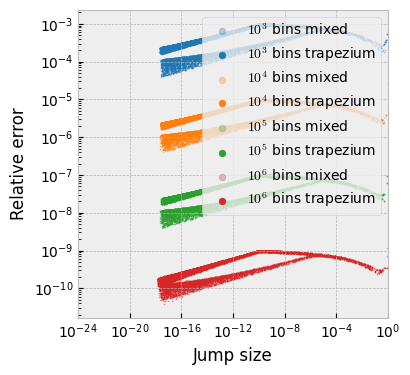

In [15]:
plot_errors_and_jump_sizes(jump_sizes, errors, n_grids, jump_sizes_trap, errors_trap, "error_stable_beta_m_1_c_2_s_01_thr_50.pdf") #

# Gamma Process accuracy

In [16]:
num_fits = 10
m = 1
n_grids = [1001, 10001, 100001, 1000001] # 

In [17]:
errors, jump_sizes = process_errors_and_jump_sizes(num_fits, gamma_process, {"m": m}, n_grids, g_gamma_process, bounds=(1e-10, np.inf), use_trap=False, thr=0.5, n_jumps=40, cache=False)

100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


In [18]:
errors_trap, jump_sizes_trap = process_errors_and_jump_sizes(num_fits, gamma_process, {"m": m}, n_grids, g_gamma_process, bounds=(1e-10, np.inf), use_trap=True, n_jumps=40, cache=False)

100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


(<Figure size 400x400 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

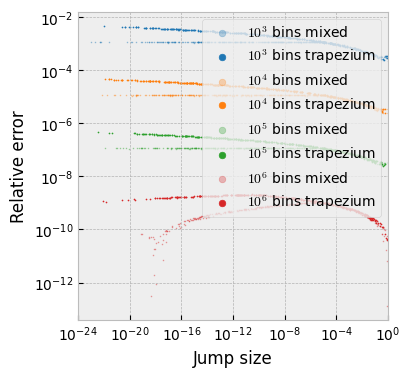

In [19]:
plot_errors_and_jump_sizes(jump_sizes, errors, n_grids, jump_sizes_trap, errors_trap, "error_gamma_m_1_thr_50.pdf") #

(<Figure size 500x500 with 1 Axes>,
 <Axes: xlabel='Jump size', ylabel='Relative error'>)

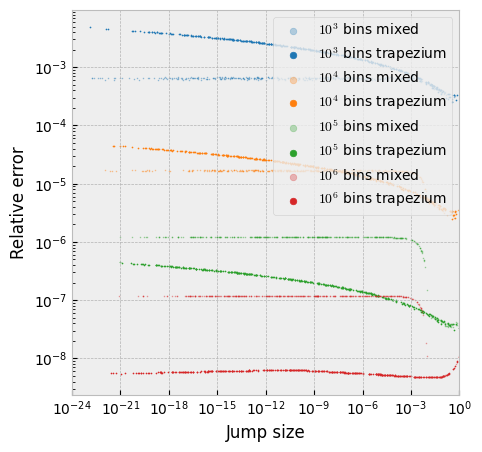

In [21]:
plot_errors_and_jump_sizes(jump_sizes, errors, n_grids, jump_sizes_trap, errors_trap, "error_gamma_m_1_thr_80.pdf") #

## Error Poisson process rate

### Beta Process

In [7]:
ms = [1, 2, 3, 5, 7, 10]
cs = [2, 3, 20]
trapezium_poi, mixed_poi = process_error_rate_vs_params([1001], {"m": ms, "c": cs}, beta_process, g_beta_process)

  0%|          | 0/18 [00:00<?, ?it/s]

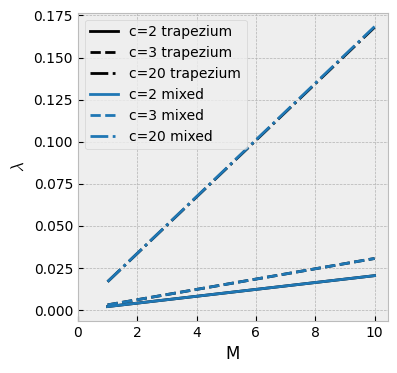

In [9]:
plot_beta_process_err_rate_vs_m(None, ms, cs, trapezium_poi, mixed_poi, "beta_poi_rate.pdf")

### Stable Beta Process

In [22]:
sigmas = [0.1, 0.3, 0.9]
ms = [1, 2, 3, 5, 7, 10]
cs = [2, 3, 20]
thresholds = [0.8]
trapezium_poi, mixed_poi = process_error_rate_vs_params([1001], {"m": ms, "c": cs, "sigma": sigmas}, stable_beta_process, g_stable_beta_process, thresholds=thresholds)

  0%|          | 0/54 [00:00<?, ?it/s]

In [22]:
calculate_integral(
            lambda x: envelope(x, stable_beta_process(10, 20, 0.9), np.logspace(-10, 0, 1000, endpoint=True), thr=0.8) - stable_beta_process(10, 20, 0.9)(x),
            (1e-10, 1e-2),
            (1e-2, 1),
        )

0.3614264848389882

In [14]:
envelope(1.5e-3, stable_beta_process(10, 20, 0.9), np.logspace(-10, 0, 1001, endpoint=True), thr=0.8)

133.27507984178374

In [11]:
envelope(1.5e-2, stable_beta_process(10, 20, 0.9), np.logspace(-10, 0, 1001, endpoint=True), thr=0.2)

3074.1586395707573

In [24]:
calculate_integral(
            lambda x: envelope(x, stable_beta_process(10, 20, 0.9), np.logspace(-10, 0, 1001, endpoint=True), g_stable_beta_process(10, 20, 0.9), thr=0.8)
            - stable_beta_process(10, 20, 0.9)(x),
            (1e-10, 1e-2),
            (1e-2, 1e-2),
        )

1.6842982629663763

In [21]:
calculate_integral(
            lambda x: envelope(x, stable_beta_process(10, 20, 0.9), np.logspace(-10, 0, 1000, endpoint=True), g_stable_beta_process(10, 20, 0.9), -1.9, thr=0.8)
            - stable_beta_process(10, 20, 0.9)(x),
            (1e-10, 1e-5),
            (1e-5, 1),
        )

1.7057705089681328

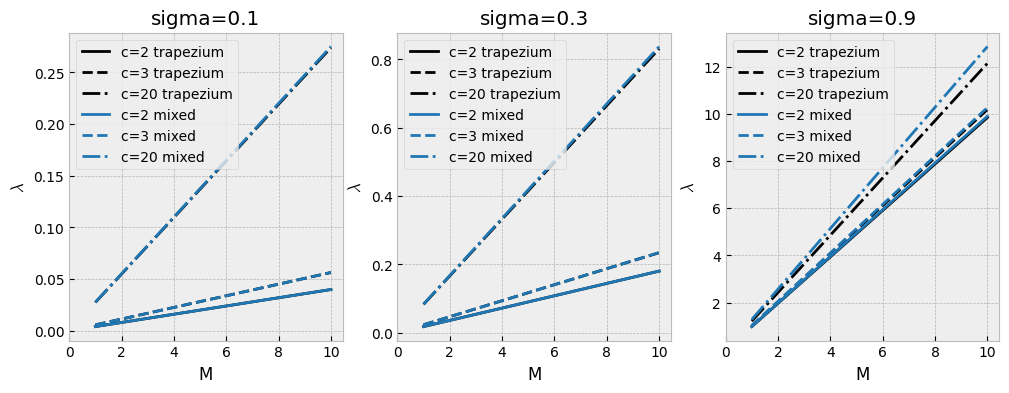

In [7]:
plot_beta_process_err_rate_vs_m(sigmas, ms, cs, trapezium_poi, mixed_poi, "stable_beta_poi_rate_1k_thr50_new.pdf")

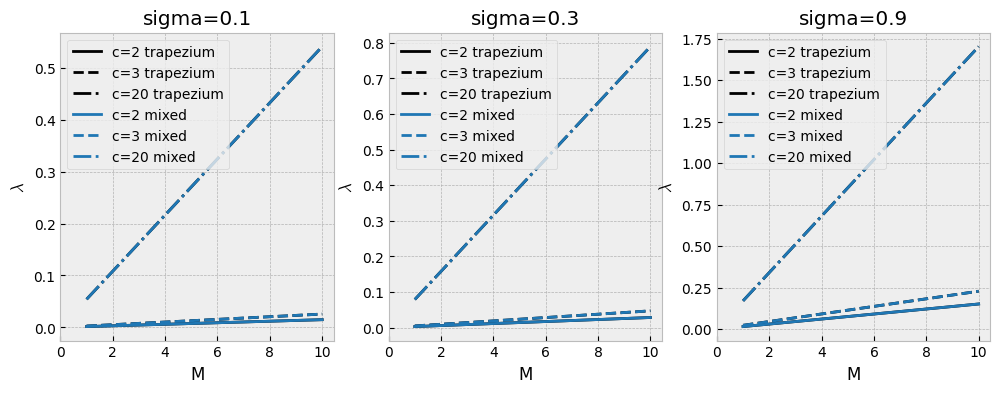

In [23]:
plot_beta_process_err_rate_vs_m(sigmas, ms, cs, trapezium_poi, mixed_poi, "stable_beta_poi_rate_1k_thr80.pdf")

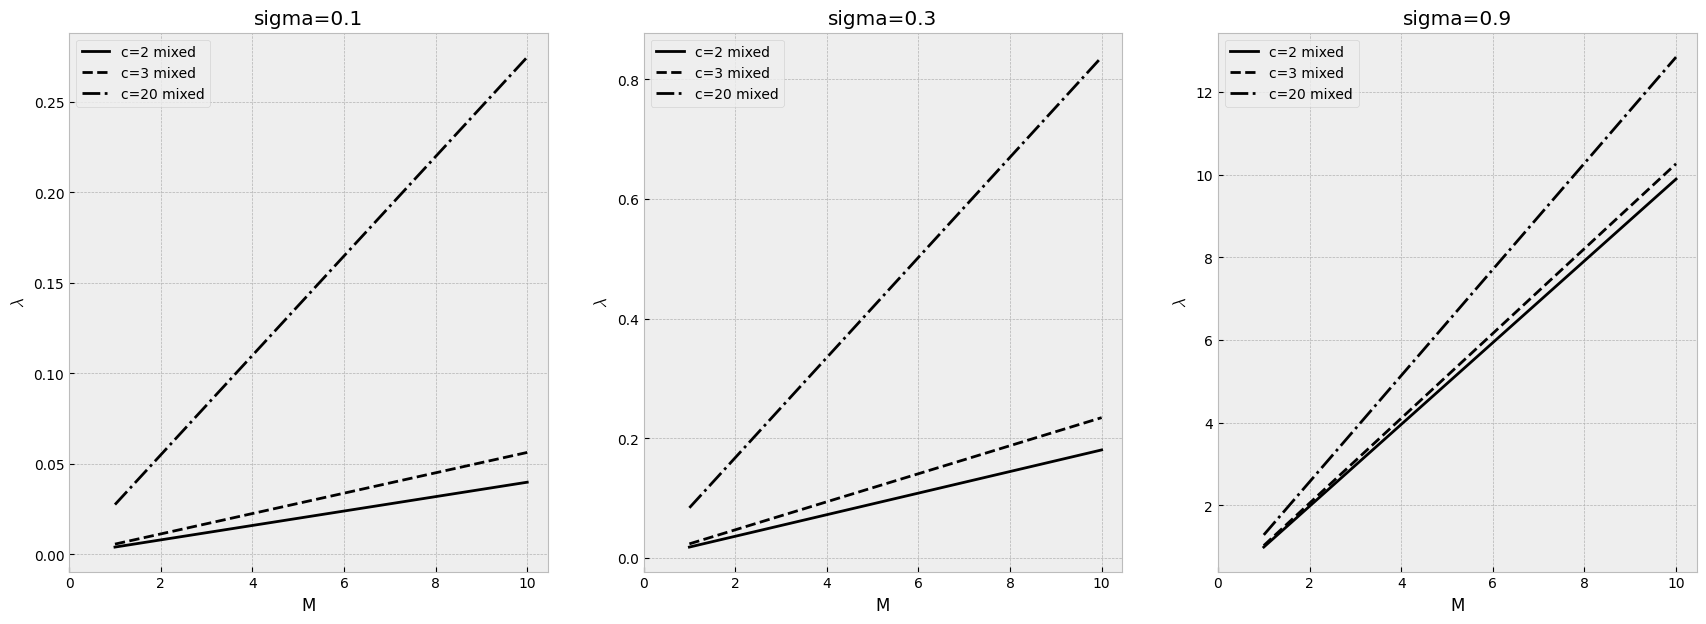

In [58]:
plot_beta_process_err_rate_vs_m(sigmas, ms, cs, None, mixed_poi, "stable_beta_poi_rate_mixed_1k.pdf")

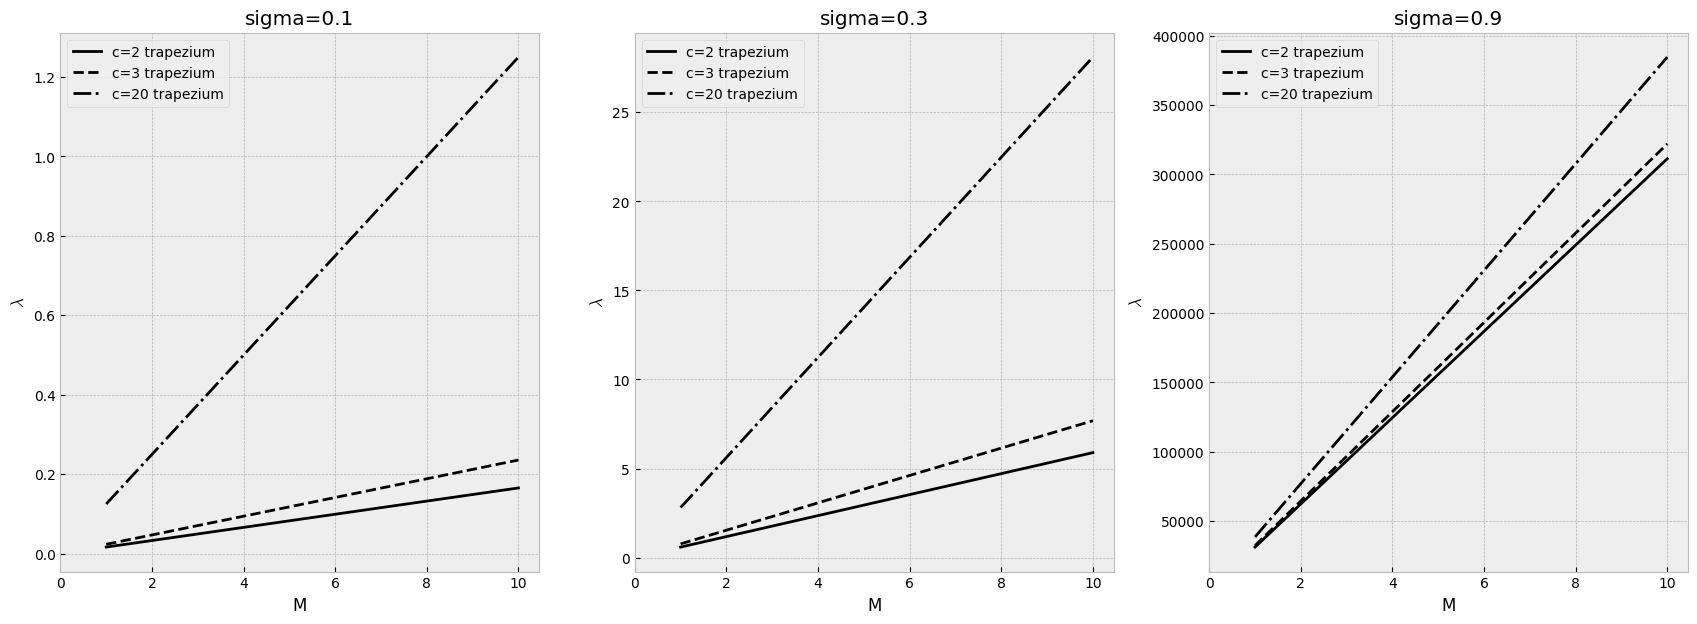

In [59]:
plot_beta_process_err_rate_vs_m(sigmas, ms, cs, trapezium_poi, None, "stable_beta_poi_rate_trapezium_1k.pdf")

### Error as a function of number of bins

#### Stable Beta

In [14]:
sigmas = [0.1, 0.3, 0.9]
ms = [1]
cs = [2, 3, 20]
num_edges = [101, 1001, 10001, 100001] # 
thresholds = [0.8]

stable_beta_error_trap, stable_beta_error_mixed = process_error_rate_vs_params(num_edges, {"m": ms, "c": cs, "sigma": sigmas}, stable_beta_process, g_stable_beta_process, thresholds=thresholds)

  0%|          | 0/36 [00:00<?, ?it/s]

D:\dev\bayes-crm\crm\utils\levy_process_utils.py:353: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axs[i].set_xlim(0, None)


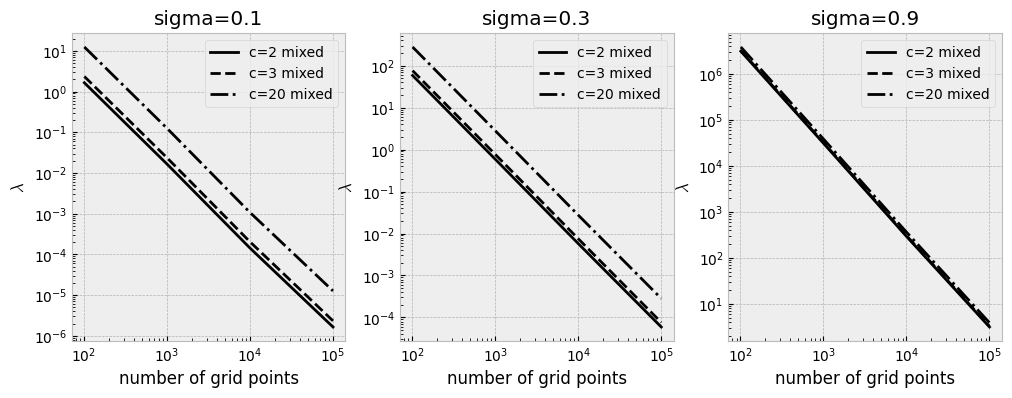

In [15]:
plot_poi_er_vs_num_grids(num_edges, {"m": ms, "c": cs, "sigma": sigmas}, stable_beta_error_trap, filename="stable_beta_poi_rate_trap_error_bin_count.pdf")

D:\dev\IBP\IBP\levy_process_utils.py:329: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axs[i].set_xlim(0, None)


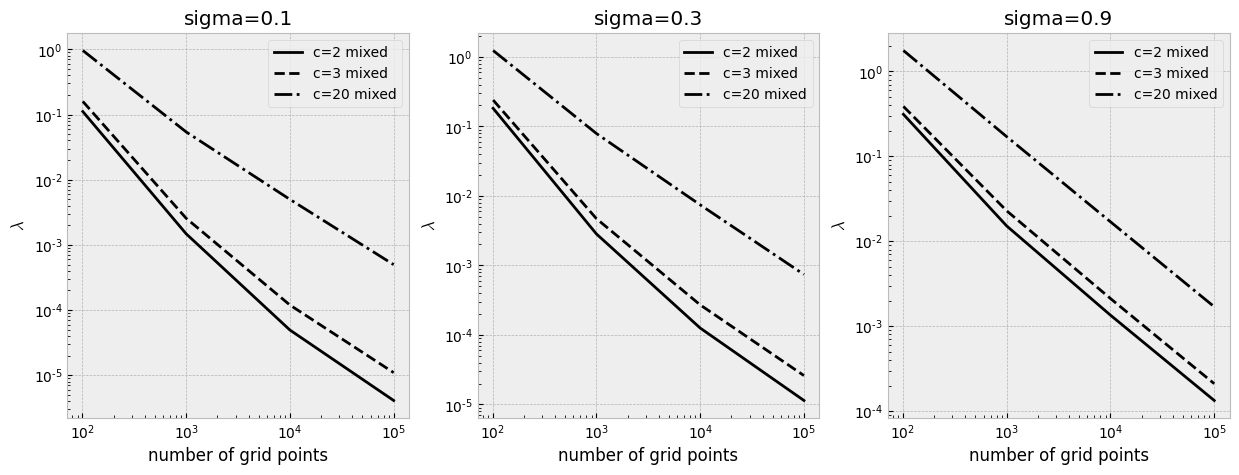

In [162]:
plot_poi_er_vs_num_grids(num_edges, {"m": ms, "c": cs, "sigma": sigmas}, stable_beta_error_mixed, filename="stable_beta_poi_rate_mixed_error_bin_count_thr_80.pdf")

D:\dev\IBP\IBP\levy_process_utils.py:224: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


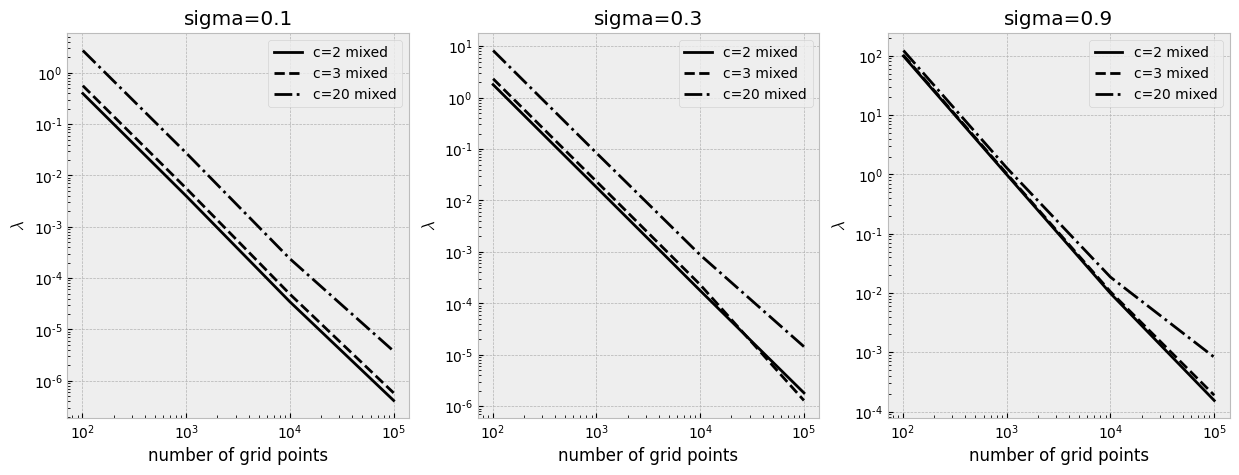

In [21]:
plot_poi_er_vs_num_grids(num_edges, {"m": ms, "c": cs, "sigma": sigmas}, stable_beta_error_mixed, filename="stable_beta_poi_rate_mixed_error_bin_count.pdf")

#### Beta

In [71]:
ms = [1]
cs = [2, 3, 20]
num_edges = [101, 1001, 10001, 100001]
thresholds = [0.5]

beta_error_trap, beta_error_mixed = process_error_rate_vs_params(num_edges, {"m": ms, "c": cs}, beta_process, g_beta_process, thresholds=thresholds)

100%|██████████| 12/12 [00:00<00:00, 293.46it/s]


D:\dev\bayes-crm\crm\utils\levy_process_utils.py:371: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, None)


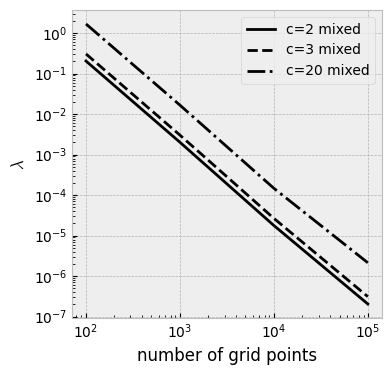

In [72]:
plot_poi_er_vs_num_grids(num_edges, {"m": ms, "c": cs,}, beta_error_mixed, filename="beta_poi_rate_mixed_error_bin_count_thr_50.pdf")

In [73]:
ms = [1]
cs = [2, 3, 20]
num_edges = [101, 1001, 10001, 100001]
thresholds = [0.8]

beta_error_trap, beta_error_mixed = process_error_rate_vs_params(num_edges, {"m": ms, "c": cs}, beta_process, g_beta_process, thresholds=thresholds)

100%|██████████| 12/12 [00:00<00:00, 6015.50it/s]


D:\dev\bayes-crm\crm\utils\levy_process_utils.py:371: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, None)


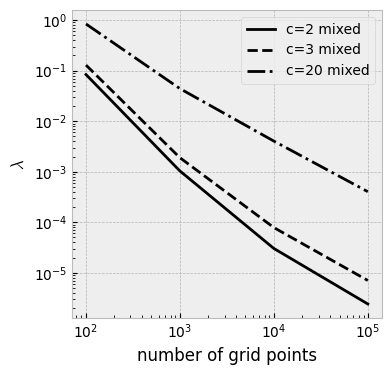

In [74]:
plot_poi_er_vs_num_grids(num_edges, {"m": ms, "c": cs,}, beta_error_mixed, filename="beta_poi_rate_mixed_error_bin_count_thr_80.pdf")

### Error rate vs threshold

#### Stable Beta Process

In [255]:
sigmas = [0.1, 0.3, 0.9]
ms = [1]
cs = [2, 3, 20]
num_edges = [1001, 10001, 100001] # 
thresholds = list(np.linspace(0.1, 0.9, 9))


stable_beta_error_trap_thr, stable_beta_error_mixed_thr = process_error_rate_vs_params(num_edges, {"m": ms, "c": cs, "sigma": sigmas}, stable_beta_process, g_stable_beta_process, thresholds=thresholds)

100%|██████████| 243/243 [2:45:23<00:00, 40.84s/it] 


##### $c = 2$

(None, <Axes: xlabel='$x_{\\text{thr}}$', ylabel='$\\lambda$'>)

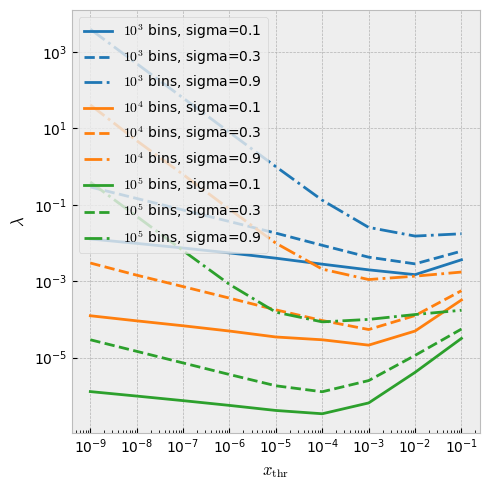

In [236]:
plot_error_vs_threshold_s(stable_beta_error_mixed_thr, num_edges, thresholds, sigmas, "stable_beta_process_mixed_error_sigma_thr.pdf")

##### $\sigma = 0.1$

(None, <Axes: xlabel='Threshold', ylabel='$\\lambda$'>)

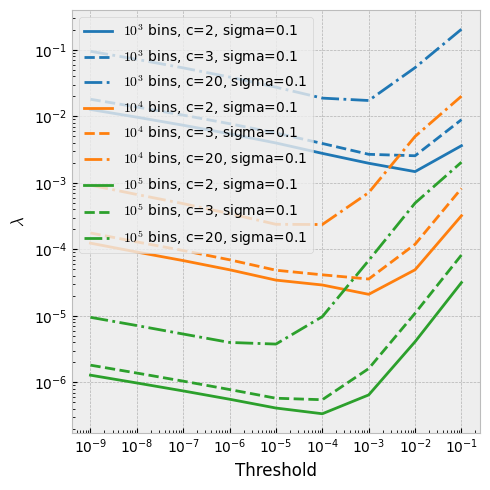

In [263]:
plot_error_vs_threshold_stable_beta_c(stable_beta_error_mixed_thr, num_edges, thresholds, cs, sigmas, 0,"stable_beta_process_mixed_error_sigma_01_thr.pdf")

##### $\sigma = 0.3$

(None, <Axes: xlabel='Threshold', ylabel='$\\lambda$'>)

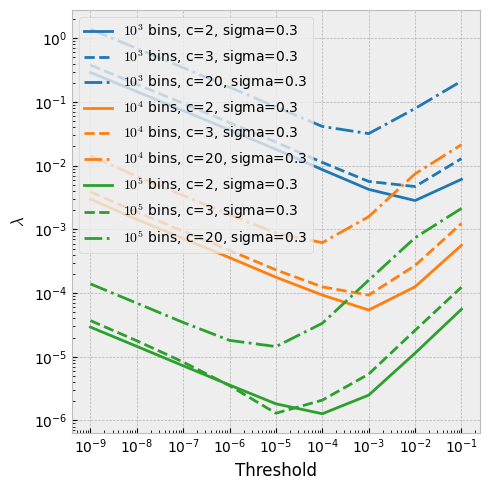

In [261]:
plot_error_vs_threshold_stable_beta_c(stable_beta_error_mixed_thr, num_edges, thresholds, cs, sigmas,"stable_beta_process_mixed_error_sigma_03_thr.pdf")

#### $\sigma = 0.9$

(None, <Axes: xlabel='Threshold', ylabel='$\\lambda$'>)

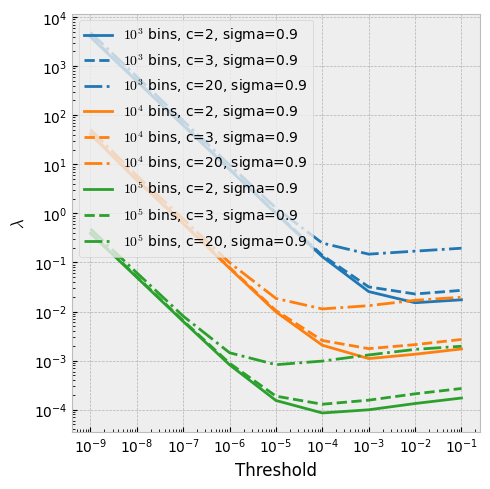

In [262]:
plot_error_vs_threshold_stable_beta_c(stable_beta_error_mixed_thr, num_edges, thresholds, cs, sigmas,"stable_beta_process_mixed_error_sigma_09_thr.pdf")

#### Beta Process

In [25]:
%%time
ms = [1, 2, 3, 5, 7, 10]
cs = [2, 3, 20]
num_edges = [1001, 10001, 100001] # 
thresholds = list(np.linspace(0.1, 0.9, 9))

beta_error_trap_thr, beta_error_mixed_thr = process_error_rate_vs_params(num_edges, {"m": ms, "c": cs}, beta_process, g_beta_process, thresholds=thresholds)

100%|██████████| 486/486 [2:28:03<00:00, 18.28s/it]  


CPU times: total: 1min 51s
Wall time: 2h 49min 54s


(None, <Axes: xlabel='Threshold', ylabel='$\\lambda$'>)

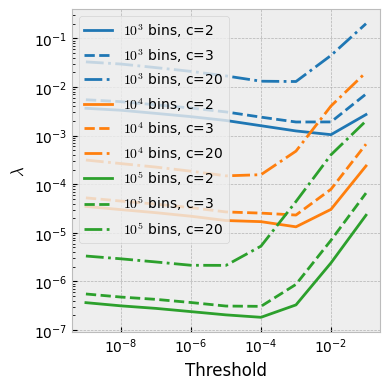

In [26]:
plot_error_vs_threshold_c(beta_error_mixed_thr, num_edges, thresholds, cs, "beta_process_mixed_error_c_thr.pdf")

In [28]:
#plot_error_vs_threshold_m(beta_error_mixed_thr, num_edges, thresholds, ms, "beta_process_mixed_error_m_thr.pdf")

# Bin plots

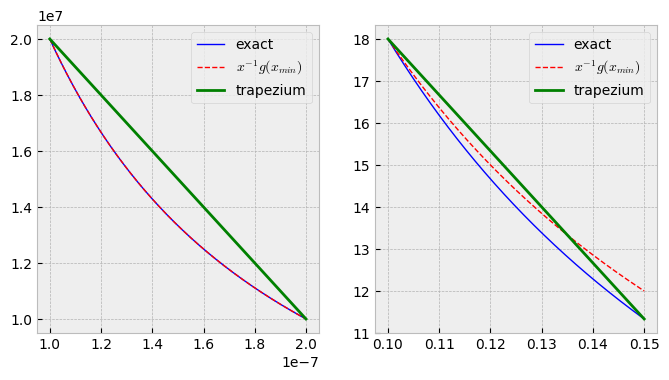

In [24]:
c = 2
m = 1
sigma = 0
ranges = [(1e-7, 2e-7), (0.1, 0.15)]  # [(lower1, upper1), (lower2, upper2)]
filename = "integration.pdf"
plot_beta_process({"c": c, "m": m}, ranges, filename, is_stable=False)

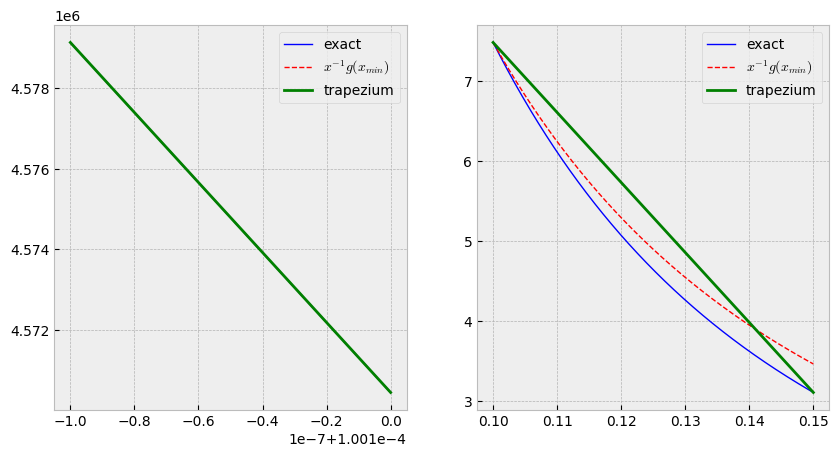

In [293]:
c = 2
m = 1
sigma = 0.9
ranges = [(1e-4, 1.001e-4), (0.1, 0.15)]  # [(lower1, upper1), (lower2, upper2)]
filename = "integration_beta_stable.pdf"
plot_beta_process({"c": c, "m": m, "sigma": sigma}, ranges, filename, is_stable=True)

In [29]:
c = 2
m = 1
xs = np.linspace(0, 80, 5001, endpoint=True)

p_trap = ApproxProcess(beta_process(m, c), 1001)
p_mix = ApproxProcess(beta_process(m, c), 1001, g_beta_process(m, c), -1)
p_prec = ApproxProcess(beta_process(m, c), 10000001)
interp_points = p_mix.generate(xs)
interp_points_trapezium = p_trap.generate(xs)
interp_points_prec = p_prec.generate(xs)
c_sum = p_mix.c_sum
c_sum_trapezium = p_trap.c_sum
c_sum_prec = p_prec.c_sum
edges = p_mix.edges
edges_prec = p_prec.edges

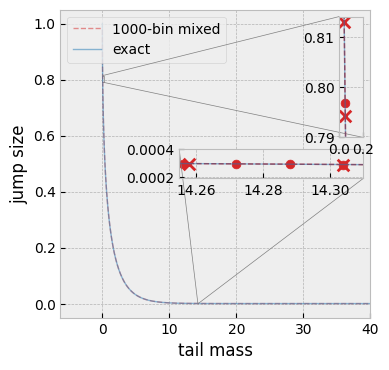

In [35]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

def create_inset(ax, zoom, loc, c_sum, edges, xs, interp_points, c_sum_prec, edges_prec, xlim, ylim):
    axins = zoomed_inset_axes(ax, zoom, loc=loc)
    axins.plot(c_sum, edges[:-1][::-1], ls="--", lw=1, c="tab:red")
    axins.scatter(c_sum, edges[:-1][::-1], marker="x", s=70, c="tab:red")
    axins.scatter(xs, interp_points, c="tab:red", s=40, marker="o")
    axins.plot(c_sum_prec, edges_prec[1:][::-1], c="tab:blue", lw=1, alpha=0.5)
    axins.set_xlim(*xlim)
    axins.set_ylim(*ylim)
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

fig, ax = plt.subplots(figsize=(4, 4))

(ln1,) = ax.plot(c_sum, edges[:-1][::-1], ls="--", lw=1, c="tab:red", alpha=0.5)
(ln2,) = ax.plot(c_sum_prec, edges_prec[:-1][::-1], lw=1, c="tab:blue", alpha=0.5)
ax.legend([ln1, ln2], [r"1000-bin mixed", "exact"], loc=2)

create_inset(ax, 500, "center right", c_sum, edges, xs, interp_points, c_sum_prec, edges_prec, (14.255, 14.31), (0.00019, 0.0004))
create_inset(ax, 18, "upper right", c_sum, edges, xs, interp_points, c_sum_prec, edges_prec, (0, 0.2), (0.79, 0.814))

ax.set_ylabel("jump size")
ax.set_xlabel("tail mass")
ax.set_xlim(None, 40)

fig.savefig("klass-ferg_1.pdf", bbox_inches="tight")

# Examples

## Example 1

In [6]:
c = 20
alpha = 2
M = 1
mixture_p = lambda x: M * c * x ** (-1) * (1 - x) ** (c - 1) + M * (
    c * (c - 1) / alpha
) * (1 - x) ** (c - 2)

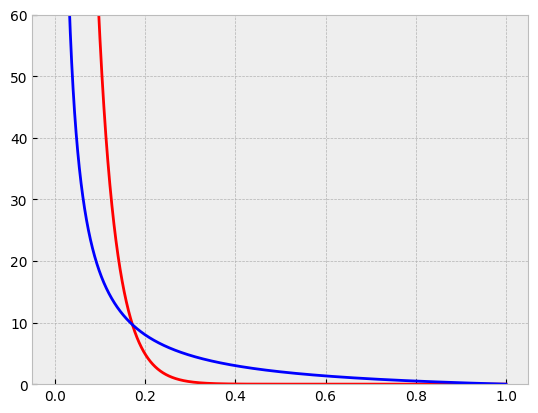

In [67]:
fig, ax = plt.subplots()
xs = np.linspace(0 + 1e-6, 1, 1000000)
ax.plot(xs, mixture_p(xs), c="red")
ax.plot(xs, beta_process(1, 2)(xs), c="blue")
ax.set_ylim(0, 60)
plt.show()

In [77]:
cs = [2, 3, 20]
ms = [1, 2, 3, 5, 7, 10]
alphas = [1, 2, 3, 10]

In [78]:
num_fits = 100
res_num = {}
res_fk = {}

for alpha in tqdm(alphas):
    res_fk[alpha] = {}
    res_num[alpha] = {}
    for c in cs:
        res_num[alpha][c] = {}
        res_fk[alpha][c] = {}
        for M in ms:
            res_fk[alpha][c][M] = measure_time_process(ferguson_klass, num_fits, mixture_p)
            # p = ApproxProcess(mixture_p, 1001, thr=0.8)
            res_num[alpha][c][M] = measure_time_approx_process(10*num_fits, mixture_p, 1001)

100%|██████████| 100/100 [01:32<00:00,  1.09it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8286.65it/s][A

100%|██████████| 100/100 [00:54<00:00,  1.83it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10551.47it/s]

100%|██████████| 100/100 [00:39<00:00,  2.52it/s]

100%|██████████| 1000/1000 [00:00<00:00, 16164.83it/s]

100%|██████████| 100/100 [00:26<00:00,  3.79it/s]

100%|██████████| 1000/1000 [00:00<00:00, 16702.59it/s]

100%|██████████| 100/100 [00:21<00:00,  4.60it/s]

100%|██████████| 1000/1000 [00:00<00:00, 16703.39it/s]

100%|██████████| 100/100 [00:18<00:00,  5.49it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15192.18it/s]

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]

100%|██████████| 1000/1000 [00:00<00:00, 5152.61it/s][A

100%|██████████| 100/100 [00:46<00:00,  2.14it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15915.19it/s]

100%|██████████| 100/100 [00:34<00:00,  2.93it/s]

100%|██████████| 1000/1000 [00:00<00:00, 15915.43it/s]

100%|██████████| 100/100 [00:24<00:

(<Figure size 1600x400 with 4 Axes>,
 array([<Axes: title={'center': '$\\xi=$1'}, xlabel='M', ylabel='Speed ratio'>,
        <Axes: title={'center': '$\\xi=$2'}, xlabel='M', ylabel='Speed ratio'>,
        <Axes: title={'center': '$\\xi=$3'}, xlabel='M', ylabel='Speed ratio'>,
        <Axes: title={'center': '$\\xi=$10'}, xlabel='M', ylabel='Speed ratio'>],
       dtype=object))

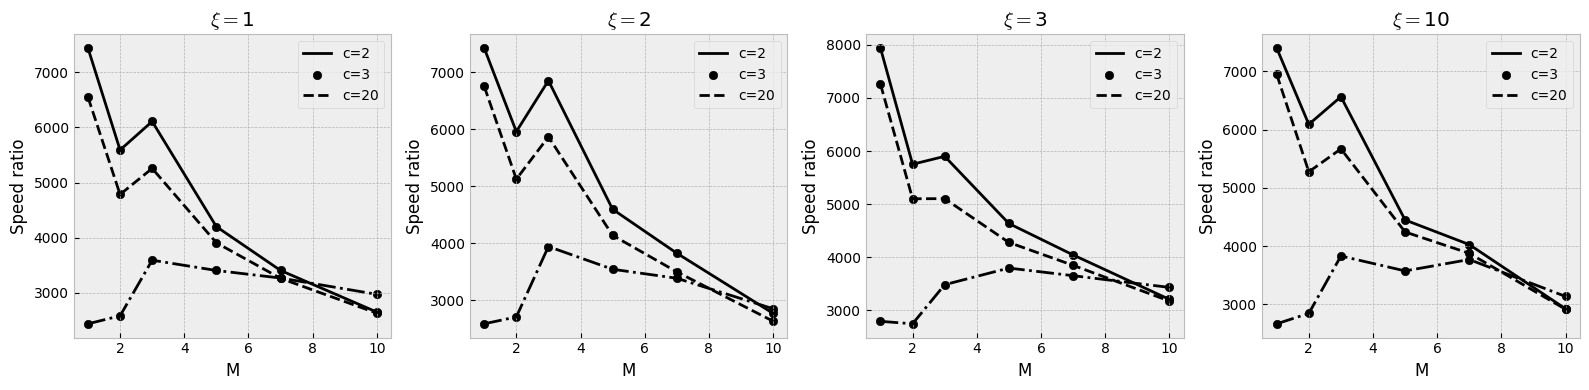

In [81]:
def plot_data_example(alphas, ms, cs, res_fk, res_num, filename=None):
    """
    This function plots the ratio of execution times of two methods for different parameters.
    
    Args:
        alphas (list): List of alpha values to be plotted.
        ms (list): List of m values to be plotted.
        cs (list): List of c values to be plotted.
        res_fk (dict): Nested dictionary with execution times of the first method. 
                       The keys are alpha, c, and m values in this order.
        res_num (dict): Nested dictionary with execution times of the second method. 
                        The keys are alpha, c, and m values in this order.

    Returns:
        None. The function shows a plot as a side effect.
    """
    
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    for j, a in enumerate(alphas):
        for i, c in enumerate(cs):
            data = np.array([res_fk[a][c][m] for m in ms]) / np.array([res_num[a][2][m] for m in ms])
            linestyle = "-" if i == 0 else "--" if i == 1 else "-."
            axs[j].plot(ms, data, c="black", ls=linestyle)
            axs[j].scatter(ms, data, c="black")
        axs[j].legend([f"c={c}" for c in cs])     
        axs[j].set_title(r"$\xi=$" + str(a))
        axs[j].set_xlabel("M")
        axs[j].set_ylabel("Speed ratio")
    plt.tight_layout()    
    if filename:
        fig.savefig(filename, bbox_inches="tight")
    
    return fig, axs

# Usage
plot_data_example(alphas, ms, cs, res_fk, res_num, "example_1.pdf")

## Occupancy model

In [4]:
from crm.models.occupancy_model import OccupancyModel, predictive

### Sample posteriors

In [5]:
np.random.seed(2)
m = 1
c = 2
theta_1 = 0.6
q_1 = 0.2
n = 10
K = 5
prior_theta = beta_process(m, c)
prior_q = st.beta(2, 2).pdf

In [6]:
Z = np.random.binomial(n=1, p=theta_1, size=n)

In [7]:
Y = np.random.binomial(n=1, p=Z * np.ones((K, n)) * q_1)

In [8]:
om = OccupancyModel(prior_theta, prior_q, n, K)

In [9]:
%%time
theta_posterior, q_cond_posterior = om.posterior(Y)
un_theta_posterior, un_q_cond_posterior = om.posterior(np.zeros(Y.shape))

CPU times: total: 672 ms
Wall time: 699 ms


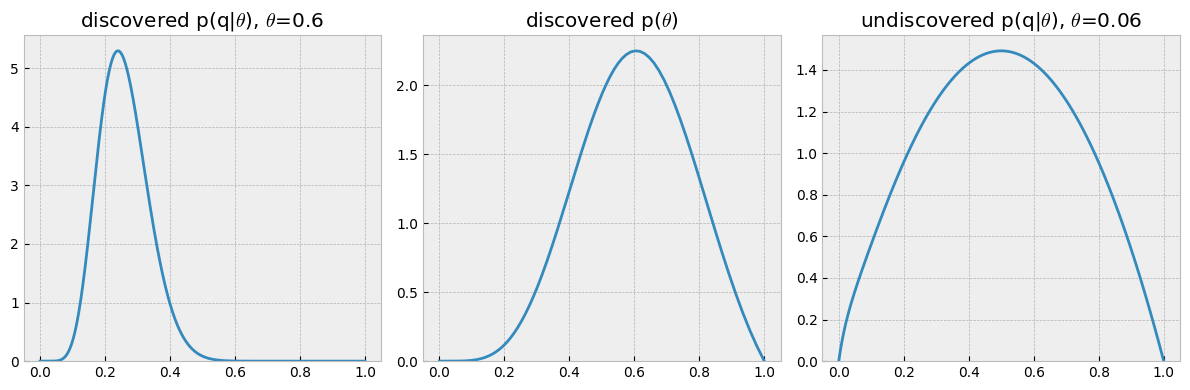

In [11]:
def plot_data(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.set_ylim(0, None)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

plot_data(axs[0], om.q_grid, q_cond_posterior(0.6), r"discovered p(q|$\theta$), $\theta$=0.6")
plot_data(axs[1], om.theta_grid, theta_posterior, r"discovered p($\theta$)")
plot_data(axs[2], om.q_grid, un_q_cond_posterior(0.06), r"undiscovered p(q|$\theta$), $\theta$=0.06")
# plot_data(axs[3], om.theta_grid, un_theta_posterior, r"undiscovered p($\theta$)")

fig.tight_layout()
fig.savefig("occupancy_model_posteriors.pdf", bbox_inches="tight")

### Occupancy model full experiment

In [56]:
m = 1
c = 2
theta_1 = 0.6
q_1 = 0.2
n = 10
K = 5
K_new = 5
prior_theta = beta_process(m, c)
prior_q = st.beta(2, 2).pdf
om = OccupancyModel(prior_theta, prior_q, n, K)

In [57]:
np.random.seed(5)
ap_theta_prior = ApproxProcess(prior_theta, thr=0.8)
probs_theta = ap_theta_prior.generate(size=40)
probs_q = st.beta(2, 2).rvs(size=40)

In [58]:
%%time
n_draws = 10000
y_obs, y_unobs = predictive(om, probs_theta, probs_q, n_draws, n, K, K_new)

40it [00:58,  1.47s/it]
100%|██████████| 10000/10000 [05:07<00:00, 32.54it/s]


CPU times: total: 2min
Wall time: 6min 7s


In [59]:
def calculate_unobserved(y_unobs, n_draws, n, K_new):
    n_prev_unobs = np.zeros(n_draws)
    n_prev_unobs_n = {i: np.zeros(n_draws) for i in range(1, n * K_new + 1)}

    for i in range(y_unobs.shape[0]):
        for j in range(n_draws):
            sm = y_unobs[i][j].sum()
            if sm > 0:
                n_prev_unobs[j] += 1
                n_prev_unobs_n[int(sm)][j] += 1

    return n_prev_unobs, n_prev_unobs_n

n_prev_unobs, n_prev_unobs_n = calculate_unobserved(y_unobs, n_draws, n, K_new)

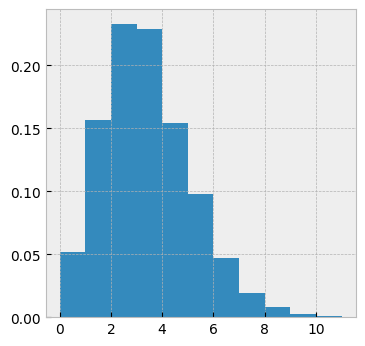

In [62]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(
    n_prev_unobs,
    bins=int(n_prev_unobs.max()),
    density=True,
    range=(0, int(n_prev_unobs.max())),
)
fig.savefig("occupancy_model_n_prev_unobs.pdf", bbox_inches="tight")

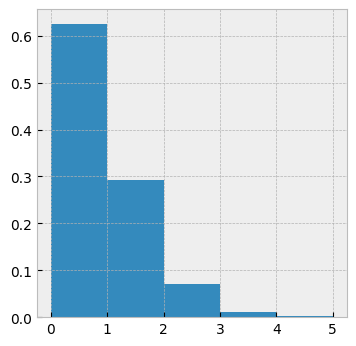

In [63]:
r = 2
fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(
    n_prev_unobs_n[r],
    bins=int(n_prev_unobs_n[r].max()),
    density=True,
    range=(0, int(n_prev_unobs_n[r].max())),
)
plt.xticks(np.arange(n_prev_unobs_n[r].min(), n_prev_unobs_n[r].max()+1, 1))
fig.savefig("occupancy_model_n_prev_unobs_r2.pdf", bbox_inches="tight")